In [1]:
import os
import torch
from torch.utils.data import DataLoader
from joblib import dump
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from data import load_data
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

circuit_vanilla = torch.load('results_pc/20240717_212612_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.0_PAT5_MOD/circuit.pt', map_location=torch.device('cpu')).to(device)
pf_vanilla = torch.load('results_pc/20240717_212612_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.0_PAT5_MOD/pf_circuit.pt', map_location=torch.device('cpu')).to(device)
circuit_vanilla.eval()
pf_vanilla.eval()
model_vanilla = (circuit_vanilla, pf_vanilla)

circuit_reg = torch.load('results_pc/20240717_221252_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.1_PAT5_MOD/circuit.pt', map_location=torch.device('cpu')).to(device)
pf_reg = torch.load('results_pc/20240717_221252_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.1_PAT5_MOD/pf_circuit.pt', map_location=torch.device('cpu')).to(device)
circuit_reg.eval()
pf_reg.eval()
model_reg = (circuit_reg, pf_reg)

circuit_reg_plus = torch.load('results_pc/20240717_234122_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.5_PAT5_MOD/circuit.pt', map_location=torch.device('cpu')).to(device)
pf_reg_plus = torch.load('results_pc/20240717_234122_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.5_PAT5_MOD/pf_circuit.pt', map_location=torch.device('cpu')).to(device)
circuit_reg_plus.eval()
pf_reg_plus.eval()
model_reg_plus = (circuit_reg_plus, pf_reg_plus)

# Samples

In [ ]:
import einops as E

samples = circuit_vanilla.sample_forward(5)
leaf_samples = samples[0]
mixtures_samples = samples[1]

leaf_samples = leaf_samples[:, 0, 0, :]
samples = E.rearrange(samples, "n (h w) -> n h w", h=28, w=28)
samples = samples.cpu().numpy()

plt.figure(figsize=(5, 1))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.show(bbox_inches="tight", pad_inches=0, transparent=True)

# KID/FID/Precision+Recall

# OOD detection

In [4]:
from util import roc_pc

batch_size = 1
_, _, test_data = load_data('mnist', './data', binarize=False, val = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
_, _, test_data_emnist = load_data('emnist', './data', binarize=False, val = True)
test_loader_emnist = DataLoader(test_data_emnist, batch_size=batch_size, shuffle=False)

fpr_vanilla, tpr_vanilla, thresholds_vanilla, roc_auc_vanilla, precision_vanilla, \
recall_vanilla, pr_thresholds_vanilla, pr_auc_vanilla, nll_mnist_vanilla, nll_emnist_vanilla \
                                     = roc_pc(test_loader, test_loader_emnist, 
                                                               model_vanilla, model_type='PC')

fpr_reg, tpr_reg, thresholds_reg, roc_auc_reg, precision_reg, \
recall_reg, pr_thresholds_reg, pr_auc_reg, nll_mnist_reg, nll_emnist_reg \
                                = roc_pc(test_loader, test_loader_emnist, model_reg, model_type='PC')

fpr_reg_plus, tpr_reg_plus, thresholds_reg_plus, roc_auc_reg_plus, precision_reg_plus, \
recall_reg_plus, pr_thresholds_reg_plus, pr_auc_reg_plus, nll_mnist_reg_plus, nll_emnist_reg_plus \
                                    = roc_pc(test_loader, test_loader_emnist, model_reg_plus, model_type='PC')

In [ ]:
nll_mnist_vanilla

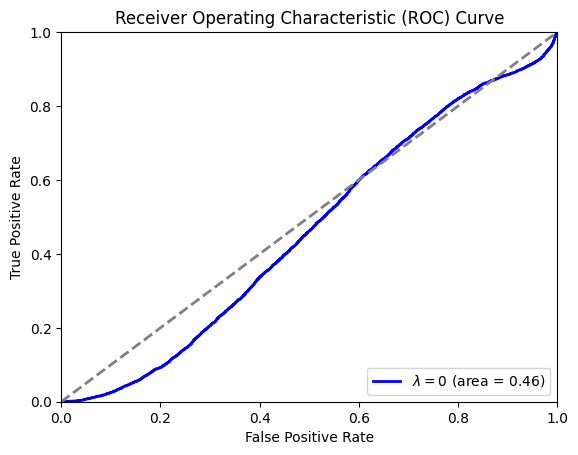

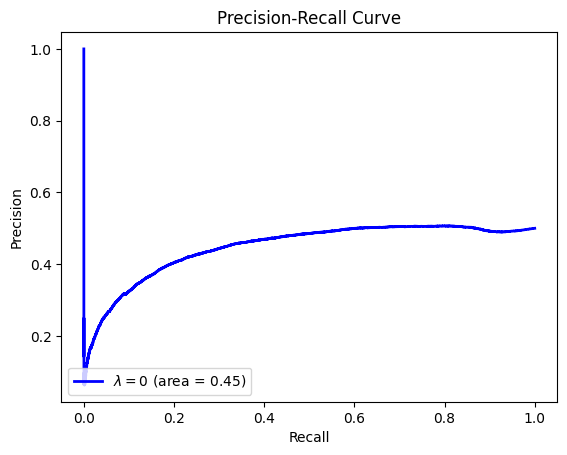

In [3]:
plt.figure()
plt.plot(fpr_vanilla, tpr_vanilla, color='blue', lw=2, label=f'$\lambda = 0$ (area = {roc_auc_vanilla:.2f})')
plt.plot(fpr_reg, tpr_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {roc_auc_reg:.2f})')
plt.plot(fpr_reg_plus, tpr_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {roc_auc_reg_plus:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall_vanilla, precision_vanilla, color='blue', lw=2, label=f'$\lambda = 0$ (area = {pr_auc_vanilla:.2f})')
plt.plot(recall_reg, precision_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {pr_auc_reg:.2f})')
plt.plot(recall_reg_plus, precision_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {pr_auc_reg_plus:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

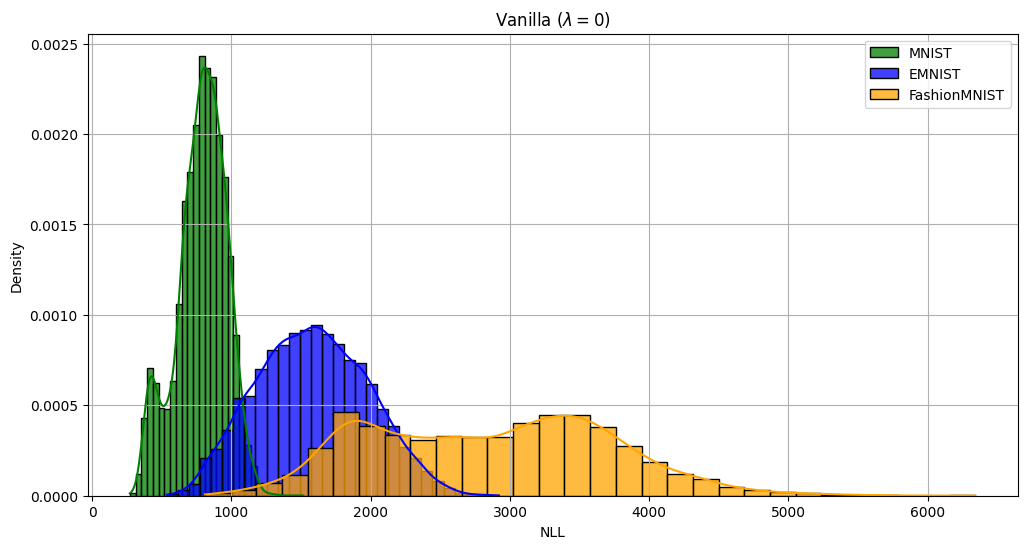

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from util import compute_nlls

_, _, test_data = load_data('mnist', './data', binarize=False, val = True)
_, _, test_data_emnist = load_data('emnist', './data', binarize=False, val = True)
#_, _, test_data_fashion = load_data('fashion', './data', binarize=False, val = True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
test_loader_emnist = DataLoader(test_data_emnist, batch_size=1, shuffle=False)
#test_loader_fashion = DataLoader(test_data_fashion, batch_size=1, shuffle=False)


nll_mnist_vanilla = compute_nlls(model_vanilla, test_loader, model_type = 'PC')
nll_emnist_vanilla = compute_nlls(model_vanilla, test_loader_emnist, model_type = 'PC')

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(-np.array(nll_mnist_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs, label='MNIST')
sns.histplot(-np.array(nll_emnist_vanilla), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs, label='EMNIST')
#sns.histplot(-np.array(test_lls_fashion_vanilla), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs, label='FashionMNIST')


axs.set_title('Vanilla ($\lambda = 0$)')
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.legend()
axs.grid(True)

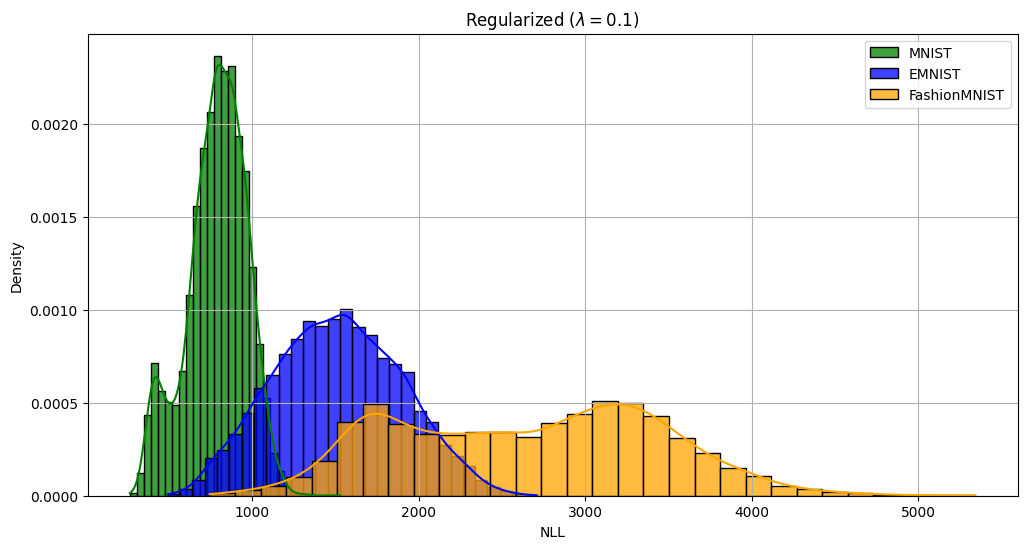

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

nll_mnist_reg = compute_nlls(model_reg, test_loader, model_type = 'PC')
nll_emnist_reg = compute_nlls(model_reg, test_loader_emnist, model_type = 'PC')

sns.histplot(-np.array(nll_mnist_reg), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs, label='MNIST')
sns.histplot(-np.array(nll_emnist_reg), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs, label='EMNIST')
#sns.histplot(-np.array(test_lls_fashion_reg), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs, label='FashionMNIST')

axs.set_title('Regularized ($\lambda = 0.1$)')
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.legend()
axs.grid(True)

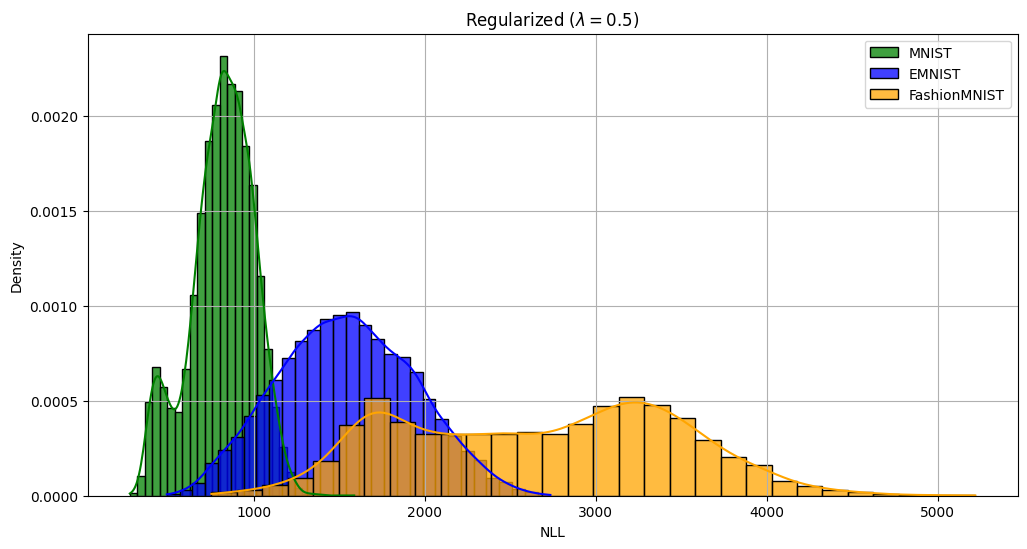

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

nll_mnist_reg_plus = compute_nlls(model_reg_plus, test_loader, model_type = 'PC')
nll_emnist_reg_plus = compute_nlls(model_reg_plus, test_loader_emnist, model_type = 'PC')

sns.histplot(-np.array(nll_mnist_reg_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs, label='MNIST')
sns.histplot(-np.array(nll_emnist_reg_plus), bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs, label='EMNIST')
#sns.histplot(-np.array(test_lls_fashion_reg_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.75, ax=axs, label='FashionMNIST')

axs.set_title('Regularized ($\lambda = 0.5$)')
axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.legend()
axs.grid(True)